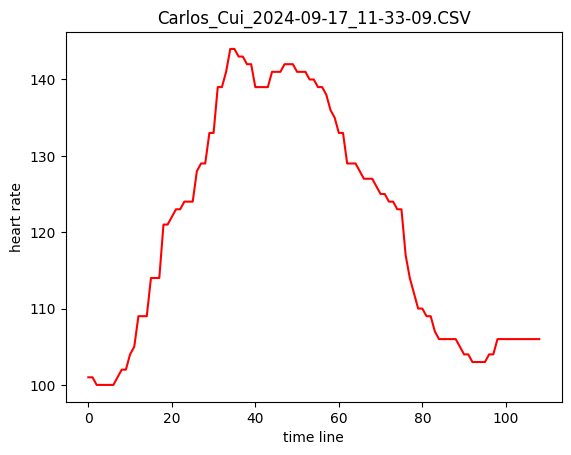

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# duration is the 5th element, 0 -> 4.
def get_heart_rate(file_name):
    csv_data = np.loadtxt(file_name, delimiter=',', skiprows=3, dtype=str)
    x = csv_data[:, 1]
    y = csv_data[:, 2]
    y = y.astype(int)
    # print(y)
    time_line = [i for i in range(len(x))]
    plt.figure()
    #plt.ylim(50, 200)
    plt.plot(time_line, y, linestyle='-', color='r')

    plt.title(file_name)
    plt.xlabel('time line')
    plt.ylabel('heart rate')
    plt.show()
    return y

heart_rate_line = get_heart_rate('Carlos_Cui_2024-09-17_11-33-09.CSV')


In [17]:
# import os

# data_folder = os.getcwd()
# all_path = os.listdir(data_folder)

# files = [f for f in all_path if os.path.isfile(os.path.join(data_folder, f))]

# for file in files:
#     if file.find("CSV") != -1:
#         plot_hr(file)



In [18]:
import xml.etree.ElementTree as ET
def read_game_log(file_name):
    # list of tuple (event_time, reaction_time)
    events_time_line = []
    reacted_time = []
    tree = ET.parse(file_name)
    events = tree.getroot()
    for time in events.iter('time'):
        events_time_line.append(float(time.text))
    
    for reat in events.iter('react'):
        reacted_time.append(float(reat.text))

    events_reaction = {}
    reactions_time = []
    for i in range(len(events_time_line)):
        start = events_time_line[i]
        end = reacted_time[i]
        reaction_time = end - start
        events_reaction[start] = reaction_time
        reactions_time.append(reaction_time)
    #print(events_reaction)
    
    return events_reaction, events_time_line, reactions_time

events_reaction_time, events, reactions_time = read_game_log('game_log.xml')

In [19]:
# print(events_reaction_time)

In [20]:
heart_rate_5 = []
def heart_blocks(heart_rate_line, events,interval = 5):
    time_heart_rate_dict = {}
    for i in events:
        time_heart_rate_dict[i] = heart_rate_line[round(i): round(i)+interval+1]
    return time_heart_rate_dict

blocks_dict = heart_blocks(heart_rate_line, events, 10)

### Need to convert heart rate in second to RR interval in order to calculate the HRV. The formula is RR = 60,000/ heart rate. (The unit of rr is ms) <br> And the HRV can be found in std function <br> !!!! The larger the interval, the larger the HRV!!!!

In [21]:
hrv_list = []
for event, block in blocks_dict.items():
    rr_interval = [60000/heart_rate_s for heart_rate_s in block]
    HRV = np.std(rr_interval)
    hrv_list.append(HRV)
    print(f'Event happened at {event}s. The heart rates are: {block}. The HRV is {HRV :.5} ms. The reaction time is: {events_reaction_time[event]}.')

Event happened at 20.0s. The heart rates are: [122 123 123 124 124 124 128 129 129 133 133]. The HRV is 14.202 ms. The reaction time is: 1.0.
Event happened at 40.0s. The heart rates are: [139 139 139 139 141 141 141 142 142 142 141]. The HRV is 3.7544 ms. The reaction time is: 2.0.
Event happened at 60.0s. The heart rates are: [133 133 129 129 129 128 127 127 127 126 125]. The HRV is 8.8374 ms. The reaction time is: 1.0.
Event happened at 65.0s. The heart rates are: [128 127 127 127 126 125 125 124 124 123 123]. The HRV is 6.3638 ms. The reaction time is: 1.0.
Event happened at 80.0s. The heart rates are: [110 109 109 107 106 106 106 106 106 105 104]. The HRV is 9.2127 ms. The reaction time is: 1.0.
Event happened at 90.0s. The heart rates are: [104 104 103 103 103 103 104 104 106 106 106]. The HRV is 6.5464 ms. The reaction time is: 1.0.


Pearson correlation: -0.6055561042040769, p-value: 0.20269400898790502
There is no linear relationship between HRV and Reaction Time
Spearman correlation: -0.6546536707079772, p-value: 0.15830242337545783
There is no non-linear relationship between HRV and Reaction Time


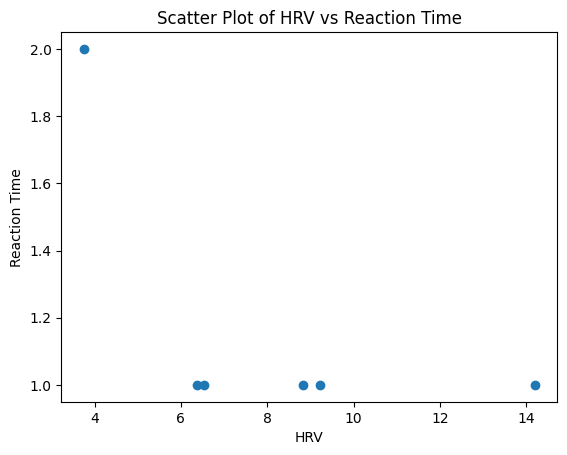

In [22]:
# pearsonr test to test whether HRV and Reaction_time has relationship.
from scipy.stats import  pearsonr, spearmanr
corr, p_value = pearsonr(hrv_list, reactions_time)
# get the linear realtionship between two datasets
print(f'Pearson correlation: {corr}, p-value: {p_value}')
if p_value >= 0.05:
    print("There is no linear relationship between HRV and Reaction Time")
else:
    print("There has linear relationship between HRV and Reaction Time")

corr, p_value = spearmanr(hrv_list, reactions_time)
# get the non-linear realtionship between two datasets
print(f'Spearman correlation: {corr}, p-value: {p_value}')
if p_value >= 0.05:
    print("There is no non-linear relationship between HRV and Reaction Time")
else:
    print("There has non-linear relationship between HRV and Reaction Time")
plt.scatter(hrv_list, reactions_time)
plt.xlabel('HRV')
plt.ylabel('Reaction Time')
plt.title('Scatter Plot of HRV vs Reaction Time')
plt.show()
# for the result: if p > 0.05 can't reject the null hyposisphy, means no relationship between two varibale.

In [24]:
# linear regression
import statsmodels.api as sm
X = sm.add_constant(hrv_list)  # Add a constant for the intercept
model = sm.OLS(reactions_time, X).fit()
print(model.summary())
# check the P value on the real dataset.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     2.316
Date:                Mon, 23 Sep 2024   Prob (F-statistic):              0.203
Time:                        15:43:47   Log-Likelihood:                -1.2210
No. Observations:                   6   AIC:                             6.442
Df Residuals:                       4   BIC:                             6.025
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7331      0.401      4.326      0.0

c:\Users\10138\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
